In [1]:
import cv2
import os
import sys
import h5py
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, LSTM, Dense, Activation, MaxPool2D, MaxPool1D, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [3]:
in_dir = "D:\Bixbyte\LSTM_HockeyFight\data"

In [4]:
# Frame size  
img_size = 224

img_size_tuple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
num_files_train = 1

# Number of frames per video
images_per_file = 20

# Number of frames per training set
num_images_train = num_files_train * images_per_file

# Video extension
video_exts = ".avi"

In [5]:
def get_frames(current_dir, file_name):   
    in_file = os.path.join(current_dir, file_name)    
    images = []    
    vidcap = cv2.VideoCapture(in_file)    
    success,image = vidcap.read()       
    count = 0

    while count < images_per_file:
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = cv2.resize(RGB_img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success,image = vidcap.read()
        count += 1
        
    result = np.array(images)    
    result = (result / 255.).astype(np.float16)     
    return result

In [6]:
def label_video_names(in_dir):   
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
       
    for current_dir, dir_names, file_names in os.walk(in_dir):      
        for file_name in file_names:     
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                                 
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)   
    names, labels = zip(*c)           
    return names, labels

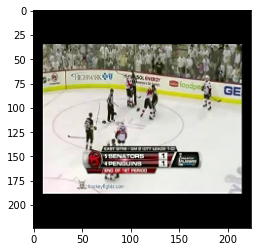

In [7]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)
names[12]
frames = get_frames(in_dir, names[12])
visible_frame = (frames*255).astype('uint8')
plt.imshow(visible_frame[3])

In [8]:
frames.shape

(20, 224, 224, 3)

In [9]:
type(names)

tuple

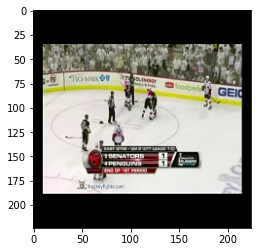

In [10]:
plt.imshow(visible_frame[15])

In [11]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (img_size, img_size, num_channels)))
model_cnn.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model_cnn.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation = "relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation = "softmax"))

In [12]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [13]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = model_cnn.get_layer('dense')

image_model_transfer = Model(inputs=model_cnn.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the CNN model have dimensions:",K.int_shape(model_cnn.input)[1:3])
print("The output of the selecter layer of CNN model have dimensions: ", transfer_values_size)

The input of the CNN model have dimensions: (224, 224)
The output of the selecter layer of CNN model have dimensions:  256


In [14]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (images_per_file,) + img_size_touple + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [15]:
def process_transfer(vid_names, in_dir, labels):
    
    count = 0
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (images_per_file,) + img_size_tuple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        image_batch = np.zeros(shape=shape, dtype=np.float16)  
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        aux = np.ones([20,2])
        labelss = labels1*aux
        yield transfer_values, labelss  
        count+=1

In [16]:
def make_files(n_files):
    
    gen = process_transfer(names_training, in_dir, labels_training)
    number = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if number == n_files:
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(number, n_files)
        
            number += 1

In [17]:
def make_files_test(n_files):
    
    gen = process_transfer(names_test, in_dir, labels_test)
    number = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if number == n_files:
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(number, n_files)
        
            number += 1

In [18]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [21]:
make_files(training_set)

- Progress: 99.9%

In [22]:
make_files_test(test_set)

- Progress: 99.5%

In [23]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [24]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [25]:
data, target = process_alldata_training()
data_test, target_test = process_alldata_test()

In [26]:
chunk_size = 256
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [27]:
seed = 1
path = 'D:\Bixbyte\LSTM_HockeyFight'
model_path = path + '\model\model_hockey_LSTM_' + str(seed) + '.h5'

early_stopping = [EarlyStopping(monitor='val_loss', patience=20), ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)]

history = model.fit(np.array(data[0:720]),
                    np.array(target[0:720]),
                    validation_data=(np.array(data[720:]), np.array(target[720:])),
                    epochs=1000,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/1000
23/23 - 6s - loss: 0.2276 - accuracy: 0.5889 - val_loss: 0.3645 - val_accuracy: 0.4875 - 6s/epoch - 239ms/step
Epoch 2/1000
23/23 - 4s - loss: 0.2579 - accuracy: 0.5653 - val_loss: 0.1959 - val_accuracy: 0.7875 - 4s/epoch - 164ms/step
Epoch 3/1000
23/23 - 4s - loss: 0.1828 - accuracy: 0.7917 - val_loss: 0.1426 - val_accuracy: 0.8875 - 4s/epoch - 168ms/step
Epoch 4/1000
23/23 - 4s - loss: 0.1112 - accuracy: 0.8736 - val_loss: 0.0938 - val_accuracy: 0.8500 - 4s/epoch - 162ms/step
Epoch 5/1000
23/23 - 4s - loss: 0.0856 - accuracy: 0.8875 - val_loss: 0.1288 - val_accuracy: 0.8250 - 4s/epoch - 165ms/step
Epoch 6/1000
23/23 - 4s - loss: 0.0965 - accuracy: 0.8750 - val_loss: 0.1004 - val_accuracy: 0.8750 - 4s/epoch - 164ms/step
Epoch 7/1000
23/23 - 4s - loss: 0.0834 - accuracy: 0.9000 - val_loss: 0.0981 - val_accuracy: 0.8625 - 4s/epoch - 169ms/step
Epoch 8/1000
23/23 - 4s - loss: 0.0757 - accuracy: 0.9014 - val_loss: 0.0606 - val_accuracy: 0.9250 - 4s/epoch - 194ms/step
Epoch 9/

In [28]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 0s 51ms/step - loss: 0.0403 - accuracy: 0.9550


In [29]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.040283747017383575
accuracy 0.9549999833106995
